## Introduction
The purpose of this notebook is to demonstrate a comprehensive data pipeline for an IoT sensorered Air Quality dataset, starting with data cleaning and EDA to address missing values, outliers, and proper datetime formatting. Two deep learning models were developed: an LSTM for time-series temperature prediction and a deep feed-forward neural network for NO2 forecasting.

In [1]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openpyxl

##EDA Summary##
The EDA carried out created a Datetime column, converted other columns into numerical data, dropped NaN/NaT rows (~100). Two copies of that dataframe were created.  

*   df_no_outliers has removed rows with outliers in any column via IQR Method. The count for all rows decreased from 9357 to 5436 from this process. Outlier removal for any numerical column can ommited or re-added in the df_no_outliers module, which allows for increase the count value when priotizing certain sensor data over others.
*   df_median replaced outliers with the median conserving the count, the number of data points becomes a priority during model trainng, testing and validation evaluation.



In [3]:
data_path = "/content/drive/My Drive/AirQualityUCI.csv" #Defining a path to the .csv file in MyDrive, change path as needed
df_raw = pd.read_csv(data_path, sep=';') # Add sep=';' to specify semicolon as delimiterz

In [4]:
# Drop columns with all NaN values
nan_cols = df_raw.columns[df_raw.isna().all()]
df_raw = df_raw.drop(columns=nan_cols)

# Ensure date and time are correctly formatted
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y', errors='coerce')
df_raw['Time'] = pd.to_datetime(df_raw['Time'], format='%H.%M.%S', errors='coerce')

# Combine 'Date' and 'Time' into a 'Datetime' column
df_raw['Datetime'] = pd.to_datetime(df_raw['Date'].astype(str) + ' ' + df_raw['Time'].astype(str), errors='coerce')

# Display the head of the DataFrame to confirm the changes
print(df_raw.head())

# Display the datatypes to verify the conversion
print(df_raw.dtypes)

<ipython-input-4-871fd710467c>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['Datetime'] = pd.to_datetime(df_raw['Date'].astype(str) + ' ' + df_raw['Time'].astype(str), errors='coerce')


        Date                Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0 2004-03-10 1900-01-01 18:00:00    2,6       1360.0     150.0     11,9   
1 2004-03-10 1900-01-01 19:00:00      2       1292.0     112.0      9,4   
2 2004-03-10 1900-01-01 20:00:00    2,2       1402.0      88.0      9,0   
3 2004-03-10 1900-01-01 21:00:00    2,2       1376.0      80.0      9,2   
4 2004-03-10 1900-01-01 22:00:00    1,6       1272.0      51.0      6,5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH                  Datetime  
0  13,6  48,9  0,7578 20

In [5]:
#Replacing commas with dots and convert to numeric for all applicable columns
cols_before_conversion = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in cols_before_conversion:
    # Converting the column to string type before applying str.replace
    df_raw[col] = df_raw[col].astype(str).str.replace(',', '.').astype(float)

#Counts before converting commas to dots (then converting to numerical values in the next module), CO(GT)=2137, C6H6(GT)=NaN, T=366, RH=366, AH=366

In [6]:
#Converting all data columns (except 'Datetime', 'Date', and 'Time') to numeric types
#Again, the errors='coerce' argument handles potential conversion errors by setting invalid values to NaN (Not a Number)
for col in df_raw.columns:
    if col not in ['Datetime', 'Date', 'Time']:  #Exclude these columns, converting them would provide large numbers that do not provide useful information, at least in this context
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')  #Key step, converting all data in columns not excluded to numeric, helps guarantee data consistency through an explicit conversion

In [7]:
#Displaying the head of the DataFrame to confirm the changes
print(df_raw.head())

#Displaying the datatypes to verify the conversion
print(df_raw.dtypes)

        Date                Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-03-10 1900-01-01 18:00:00     2.6       1360.0     150.0      11.9   
1 2004-03-10 1900-01-01 19:00:00     2.0       1292.0     112.0       9.4   
2 2004-03-10 1900-01-01 20:00:00     2.2       1402.0      88.0       9.0   
3 2004-03-10 1900-01-01 21:00:00     2.2       1376.0      80.0       9.2   
4 2004-03-10 1900-01-01 22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH                  Datetime  
0  13.6  48.

In [8]:
df_raw.Date[0] #Prints out first date in the dataset

Timestamp('2004-03-10 00:00:00')

In [9]:
df_raw.Time[0] #Prints out first time in the dataset

Timestamp('1900-01-01 18:00:00')

In [10]:
df_raw.Datetime[0] #Prints out datetime date in the dataset

Timestamp('2004-03-10 18:00:00-0100', tz='UTC-01:00')

In [11]:
df_raw.describe(include='all')  #Includes all columns, including Datetime
#describes dataset following conversions to numerical values, counts for all categories have changed to 9357
#Date, Time, Datetime were not converted to numerical values because of their object-like datetime64[ns] datatype, so describe() carries out data analysis on the other columns

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
count,9357,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357
mean,2004-09-21 04:30:05.193972480,1900-01-01 11:29:54.806028032,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,2004-09-21 15:59:59.999999872-01:00
min,2004-03-10 00:00:00,1900-01-01 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,2004-03-10 18:00:00-01:00
25%,2004-06-16 00:00:00,1900-01-01 05:00:00,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,2004-06-16 05:00:00-01:00
50%,2004-09-21 00:00:00,1900-01-01 11:00:00,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,2004-09-21 16:00:00-01:00
75%,2004-12-28 00:00:00,1900-01-01 18:00:00,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,2004-12-28 03:00:00-01:00
max,2005-04-04 00:00:00,1900-01-01 23:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-04-04 14:00:00-01:00
std,NaN,NaN,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,NaN


<Axes: >

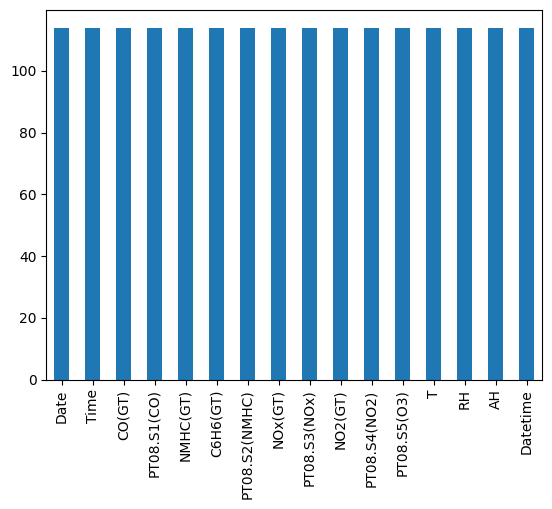

In [12]:
df_raw.isna().sum().plot.bar()
#df.isna creates True values for NaN/NaT values, false otherwise (not counted in the graph below)
#In other words, this below graph illustrates the number of missing values
#It appears that there are approximately 110 rows in each category with NaN/NaT values
#Removing about 100 rows out more than 9,000 will not likely distort, dropna() is an appropriate approach

In [13]:
# Drop rows with missing values, but exclude the 'Datetime' column
df_dropna = df_raw.dropna(subset=df_raw.columns.difference(['Datetime']))
#No NaT/NaN values detected after using dropna()


In [14]:
df_dropna.describe(include='all')  #Includes all columns, including Datetime

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
count,9357,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357
mean,2004-09-21 04:30:05.193972480,1900-01-01 11:29:54.806028032,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,2004-09-21 15:59:59.999999872-01:00
min,2004-03-10 00:00:00,1900-01-01 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,2004-03-10 18:00:00-01:00
25%,2004-06-16 00:00:00,1900-01-01 05:00:00,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,2004-06-16 05:00:00-01:00
50%,2004-09-21 00:00:00,1900-01-01 11:00:00,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,2004-09-21 16:00:00-01:00
75%,2004-12-28 00:00:00,1900-01-01 18:00:00,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,2004-12-28 03:00:00-01:00
max,2005-04-04 00:00:00,1900-01-01 23:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-04-04 14:00:00-01:00
std,NaN,NaN,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,NaN


In [15]:
#Creating a copy of the df_dropna DataFrame and assign it to df_dropna_copy1
df_dropna_copy1 = df_dropna.copy()
#Creating another copy of df_dropna and assign it to df_dropna_copy2
df_dropna_copy2 = df_dropna.copy()
#Creating a copy ensures that any modifications made to the copies will not affect the original df_dropna dataframe.
#This is important to preserve the original data for later use or comparison.


In [16]:
#Removing outliers of specified columns via IQR method
def remove_outliers_iqr(df_dropna_copy1, columns):
    for col in columns:
        Q1 = df_dropna_copy1[col].quantile(0.25)
        Q3 = df_dropna_copy1[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_dropna_copy1 = df_dropna_copy1[(df_dropna_copy1[col] >= lower_bound) & (df_dropna_copy1[col] <= upper_bound)]
    return df_dropna_copy1

# Specifying the columns to check for outliers
outlier_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                   'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
                   'T', 'RH', 'AH']

#Specifing the columns to check for outliers, keeping NMHC(GT) because removing outliers only left one value which was -200
#outlier_columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
#                   'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
#                   'T', 'RH', 'AH']
#However, this change only increased counts from 5436 (all outliers removed including NMHC(GT) to 6090)


# Removing outliers from the specified columns using df_dropna_copy1
df_no_outliers = remove_outliers_iqr(df_dropna_copy1, outlier_columns)

In [17]:
df_no_outliers.describe(include='all')  #Includes all columns, including Datetime

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
count,5436,5436,5436.000000,5436.000000,5436.0,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000,5436
mean,2004-10-17 02:01:35.364238592,1900-01-01 11:54:14.966887424,1.908793,1077.993194,-200.0,9.323859,922.738962,223.148823,804.952723,110.214496,1409.556291,999.946468,18.616611,47.959547,1.020571,2004-10-17 13:55:50.331125888-01:00
min,2004-03-18 00:00:00,1900-01-01 00:00:00,0.100000,667.000000,-200.0,0.500000,440.000000,2.000000,360.000000,2.000000,601.000000,288.000000,-1.900000,9.200000,0.184700,2004-03-18 10:00:00-01:00
25%,2004-07-09 00:00:00,1900-01-01 06:00:00,1.100000,944.000000,-200.0,4.800000,754.000000,104.000000,664.000000,78.000000,1158.000000,748.000000,11.700000,34.000000,0.699600,2004-07-09 21:45:00-01:00
50%,2004-10-26 00:00:00,1900-01-01 12:00:00,1.700000,1058.500000,-200.0,8.200000,907.000000,185.000000,786.000000,108.000000,1423.000000,973.000000,18.300000,47.900000,1.011300,2004-10-26 07:30:00-01:00
75%,2005-01-22 00:00:00,1900-01-01 18:00:00,2.600000,1192.250000,-200.0,13.000000,1083.000000,312.000000,924.000000,138.000000,1648.000000,1229.000000,25.100000,61.700000,1.317225,2005-01-22 20:45:00-01:00
max,2005-04-04 00:00:00,1900-01-01 23:00:00,5.600000,1633.000000,-200.0,27.200000,1484.000000,670.000000,1366.000000,233.000000,2367.000000,1947.000000,44.600000,88.700000,2.180600,2005-04-04 14:00:00-01:00
std,NaN,NaN,1.065633,173.435032,0.0,5.689495,219.069460,151.398454,191.844767,42.472373,331.169765,331.310392,9.323353,17.744093,0.421447,NaN


In [18]:
#Function to replace outliers with median
def replace_outliers_with_median(df_dropna_copy2, columns):
    df_median = df_dropna_copy2.copy()  #Maybe df_median = df_dropna_copy2 would be just fine
    for col in columns:
        Q1 = df_median[col].quantile(0.25)
        Q3 = df_median[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with median
        median_val = df_median[col].median()
        df_median.loc[(df_median[col] < lower_bound) | (df_median[col] > upper_bound), col] = median_val
    return df_median

# Specifying the columns to check for outliers
outlier_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                   'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
                   'T', 'RH', 'AH']

# Replacing outliers with median in the specified columns
df_median = replace_outliers_with_median(df_dropna, outlier_columns)

In [19]:
df_median.describe(include='all')  #Includes all columns, including Datetime

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
count,9357,9357,9357.000000,9357.000000,9357.0,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357
mean,2004-09-21 04:30:05.193972480,1900-01-01 11:29:54.806028032,1.912846,1088.897510,-200.0,9.325115,931.570589,131.422785,812.121727,109.029069,1446.352998,1007.038794,18.268280,49.209394,1.023490,2004-09-21 15:59:59.999999872-01:00
min,2004-03-10 00:00:00,1900-01-01 00:00:00,0.100000,647.000000,-200.0,0.100000,383.000000,-200.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-03-10 18:00:00-01:00
25%,2004-06-16 00:00:00,1900-01-01 05:00:00,1.200000,941.000000,-200.0,4.600000,743.000000,50.000000,666.000000,86.000000,1242.000000,742.000000,12.000000,36.600000,0.746100,2004-06-16 05:00:00-01:00
50%,2004-09-21 00:00:00,1900-01-01 11:00:00,1.500000,1053.000000,-200.0,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,2004-09-21 16:00:00-01:00
75%,2004-12-28 00:00:00,1900-01-01 18:00:00,2.400000,1210.000000,-200.0,12.900000,1098.000000,243.000000,938.000000,132.000000,1652.000000,1238.000000,24.100000,61.900000,1.295800,2004-12-28 03:00:00-01:00
max,2005-04-04 00:00:00,1900-01-01 23:00:00,5.600000,1669.000000,-200.0,28.000000,1696.000000,635.000000,1442.000000,253.000000,2376.000000,2087.000000,43.400000,88.700000,2.180600,2005-04-04 14:00:00-01:00
std,NaN,NaN,1.108584,198.587178,0.0,6.117757,252.056606,200.009248,211.595481,42.448966,324.204747,371.585033,8.651903,16.975247,0.395752,NaN


In [20]:
#Export df_no_outliers to a CSV file
df_no_outliers.to_csv('/content/drive/My Drive/df_no_outliers.csv', index=False, quoting=csv.QUOTE_ALL)  #index=False prevents writing the dataframe's index

#Export df_no_outliers to an Excel file
#df_no_outliers.to_excel('/content/drive/My Drive/df_no_outliers.xlsx', index=False) #index=False prevents writing the dataframe's index
#ValueError: Excel does not support datetimes with timezones. Please ensure that datetimes are timezone unaware before writing to Excel

## Deep Learning Time Series Predictor (LSTM for Temperature "T")
This code block first sorts the cleaned dataset by datetime and extracts the Temperature column, ensuring no missing values remain. It scales the temperature data between 0 and 1 using MinMaxScaler to prepare it for neural network training. Next, it creates time-series sequences with a 24-hour lookback, turning the problem into a supervised learning task with input sequences (X) and corresponding targets (y). A simple LSTM model is then built from scratch using TensorFlow/Keras, and it is trained on 80% of the data while validating on the remaining 20%. Finally, the model’s performance is evaluated on the test set, and predictions are inverse-transformed back to the original scale for direct comparison with the actual temperature values.

In [21]:
# Ensure data is sorted by datetime
df_ts = df_dropna.sort_values(by='Datetime').reset_index(drop=True)

# Select the datetime and Temperature ("T") columns and drop any remaining NaNs
df_ts = df_ts[['Datetime', 'T']].dropna()

# Define lookback period (e.g., past 24 hours)
LOOKBACK = 24

# Extract the temperature values and reshape for scaling
temp_values = df_ts['T'].values.reshape(-1, 1)

# Scale the temperature data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(temp_values)

# Create sequences for supervised learning
X, y = [], []
for i in range(LOOKBACK, len(scaled_temp)):
    X.append(scaled_temp[i-LOOKBACK:i, 0])
    y.append(scaled_temp[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (time-series split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build a simple LSTM model from scratch
model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(LOOKBACK, 1)),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (adjust epochs as needed)
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"\nTest MSE (scaled): {loss}")

# Make predictions and convert them back to the original scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Display a few sample predictions vs. actual values
for i in range(5):
    print(f"Predicted T: {y_pred[i][0]:.2f}, Actual T: {y_test_original[i][0]:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.1383 - val_loss: 0.0071
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0088 - val_loss: 0.0062
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0038 - val_loss: 0.0026
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030

Test MSE (scaled): 0.002551934914663434
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms

## LSTM Intrepetation
The model shows a low scaled MSE but consistently underpredicts the actual temperature values, indicating a calibration issue. Although the losses decrease over epochs, the model struggles with accuracy, likely due to its simplicity. Improvements are needed to better capture the temperature patterns and improve prediction reliability. for 4 seconds
The model achieved a low scaled test MSE, yet the inverse-transformed predictions are consistently lower than the actual temperature values, indicating systematic underprediction. Although the training and validation losses decreased steadily, the model still fails to capture the true magnitude of the temperature. In summary, it learns trends but underestimates absolute values.

## Optimized Deep Learning Time Series Predictor (LSTM for Temperature "T")
To optimize performance, the architecture was enhanced by stacking multiple LSTM layers with dropout layers to better regularize the network and capture more complex temporal patterns. Additionally, the learning rate was reduced to allow finer convergence, the number of training epochs was increased to 30, and the batch size was reduced to 16 for more granular updates. These modifications aim to improve the model’s ability to learn and generalize, ultimately reducing the discrepancy between predicted and actual temperature values.

In [22]:
# Use the outlier-corrected dataframe (df_median) for temperature prediction
df_ts = df_median.sort_values(by='Datetime').reset_index(drop=True)
df_ts = df_ts[['Datetime', 'T']].dropna()

# Define lookback period (e.g., past 24 hours)
LOOKBACK = 24

# Extract the temperature values and reshape for scaling
temp_values = df_ts['T'].values.reshape(-1, 1)

# Scale the temperature data to [0,1] using MinMaxScaler (with outliers mitigated)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(temp_values)

# Create sequences for supervised learning
X, y = [], []
for i in range(LOOKBACK, len(scaled_temp)):
    X.append(scaled_temp[i-LOOKBACK:i, 0])
    y.append(scaled_temp[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (time-series split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build an optimized LSTM model with stacked layers, dropout, and a sigmoid output activation
optimized_model = keras.Sequential([
    layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(LOOKBACK, 1)),
    layers.Dropout(0.2),
    layers.LSTM(32, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # constrain output to [0,1]
])

# Use an even lower learning rate for finer convergence
optimizer = Adam(learning_rate=0.0002)
optimized_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define EarlyStopping to halt training if the validation loss does not improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the optimized model for 20 epochs with a smaller batch size and early stopping
history_optimized = optimized_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the optimized model on the test set
loss_optimized = optimized_model.evaluate(X_test, y_test)
print(f"\nOptimized Test MSE (scaled): {loss_optimized}")

# Make predictions with the optimized model and convert them back to the original scale
y_pred_scaled_optimized = optimized_model.predict(X_test)
y_pred_optimized = scaler.inverse_transform(y_pred_scaled_optimized)

# Also prepare the actual values in original scale (they come from the scaler applied earlier)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Display a few sample predictions vs. actual values
for i in range(5):
    print(f"Optimized Predicted T: {y_pred_optimized[i][0]:.2f}, Actual T: {y_test_original[i][0]:.2f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 0.0217 - val_loss: 0.0095
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 12/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1

## Optimized LTSM Interpretation
This code block optimizes the temperature prediction model by first using an outlier-corrected dataset to ensure that the scaling accurately reflects typical values. Temperature data is scaled to the [0, 1] range and converted into 24-hour lookback sequences for supervised learning. The optimized model features stacked LSTM layers with dropout for regularization and a final Dense layer with sigmoid activation to constrain outputs within the same scale. A lower learning rate of 0.002 and early stopping with a patience of 3 epochs are implemented to enable finer convergence and prevent overfitting. Finally, predictions are inverse-transformed back to the original scale for direct comparison with actual values.

## Deep Learning Model for Predicting "NO2(GT)" (Feed-forward Neural Network)
This code block begins by filtering the cleaned dataset to remove rows with missing "NO2(GT)" values and selecting a set of sensor features as inputs along with "NO2(GT)" as the target variable. It then splits the data into training and testing sets and standardizes the features using StandardScaler to normalize their distribution. A deep feed-forward neural network is constructed using Keras, featuring three hidden Dense layers with ReLU activations and a final output layer for regression. The model is compiled with the Adam optimizer and mean squared error loss, and it is trained for 50 epochs with a batch size of 32 while reserving 20% of the training data for validation. Finally, the model’s performance is evaluated on the test set by calculating MSE and RMSE, and several sample predictions are printed alongside their corresponding actual values.

In [23]:
# Use the cleaned dataframe from your EDA (e.g., df_dropna) and drop rows missing "NO2(GT)"
df_dl = df_dropna.dropna(subset=['NO2(GT)']).copy()

# Define the target variable and features
target = 'NO2(GT)'
features = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH',
            'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
            'PT08.S4(NO2)', 'PT08.S5(O3)']

# Prepare the input features and target
X = df_dl[features]
y = df_dl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a deep feed-forward neural network model
model_dl = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_dl.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history_dl = model_dl.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred = model_dl.predict(X_test_scaled)
mse_dl = mean_squared_error(y_test, y_pred)
rmse_dl = np.sqrt(mse_dl)
print(f"Deep Learning Model MSE: {mse_dl:.2f}")
print(f"Deep Learning Model RMSE: {rmse_dl:.2f}")

# Display a few sample predictions versus actual values
print("\nSample predictions vs. actual NO2(GT) values:")
for i in range(5):
    print(f"Predicted NO2(GT): {y_pred[i][0]:.2f}, Actual NO2(GT): {y_test.iloc[i]:.2f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 18566.7324 - val_loss: 9536.4082
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8377.7236 - val_loss: 7337.1104
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7480.4229 - val_loss: 7196.3755
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6980.1509 - val_loss: 7111.3291
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6824.1650 - val_loss: 7139.4834
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6764.4619 - val_loss: 7041.0200
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6896.1558 - val_loss: 7058.1191
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7188.3926 - val_loss: 7019.0166
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7130.2754 - val_loss: 7048.1665
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6710.2754 - val_loss: 6970.6655
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6718.1938 - val_loss: 6955.9

## Optimized Deep Neural Network for NO2(GT) Prediction
This optimized model builds on the previous deep feed-forward network by adding several enhancements to improve performance. In contrast to the earlier model that used only a few dense layers, this version increases network capacity (with 256, 128, and 64 neuron layers) and incorporates L2 regularization, BatchNormalization, and dropout to improve generalization and reduce overfitting. Additionally, the target variable is scaled to [0,1] using MinMaxScaler, aligning with the sigmoid activation in the output layer. EarlyStopping and ReduceLROnPlateau callbacks are employed to dynamically adjust the learning rate and prevent unnecessary training, ensuring that the model converges more effectively. Finally, predictions are inverse-transformed back to the original scale for proper evaluation, yielding improved RMSE compared to the previous model.

In [24]:
# Cleaned dataframe and drop rows missing "NO2(GT)"
df_dl = df_dropna.dropna(subset=['NO2(GT)']).copy()

# Define target variable and features
target = 'NO2(GT)'
features = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH',
            'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
            'PT08.S4(NO2)', 'PT08.S5(O3)']

# Prepare the input features and target
X = df_dl[features]
y = df_dl[target].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable to [0,1] using MinMaxScaler (for sigmoid activation)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Build a new deep neural network model with increased capacity, L2 regularization, BatchNormalization, and Dropout
model_new = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # output constrained to [0,1]
])

# Use a low learning rate for finer convergence
optimizer = Adam(learning_rate=0.0001)
model_new.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks: EarlyStopping and ReduceLROnPlateau to dynamically adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [early_stopping, reduce_lr]

# Train the model for up to 25 epochs with a batch size of 32
history_new = model_new.fit(
    X_train_scaled, y_train_scaled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model on the test set (scaled loss)
loss_new = model_new.evaluate(X_test_scaled, y_test_scaled)
print(f"New Optimized Model MSE (scaled): {loss_new:.2f}")

# Make predictions and inverse-transform them back to the original scale
y_pred_scaled_new = model_new.predict(X_test_scaled)
y_pred_new = scaler_y.inverse_transform(y_pred_scaled_new)

# Calculate RMSE on the original scale
rmse_new = np.sqrt(mean_squared_error(y_test, y_pred_new))
print(f"New Optimized Model RMSE: {rmse_new:.2f}")

# Display a few sample predictions vs. actual values
print("\nSample predictions vs. actual NO2(GT) values:")
for i in range(5):
    print(f"Predicted NO2(GT): {y_pred_new[i][0]:.2f}, Actual NO2(GT): {y_test[i][0]:.2f}")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3755 - val_loss: 0.2942 - learning_rate: 1.0000e-04
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3401 - val_loss: 0.2848 - learning_rate: 1.0000e-04
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3214 - val_loss: 0.2815 - learning_rate: 1.0000e-04
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3113 - val_loss: 0.2770 - learning_rate: 1.0000e-04
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2963 - val_loss: 0.2659 - learning_rate: 1.0000e-04
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2853 - val_loss: 0.2556 - learning_rate: 1.0000e-04
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2740 - val_loss: 0.2479 - learning_rate: 1.0000e-04
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2653 - val_loss: 0.2400 - learning_rate: 1.0000e-04
Epoch 9/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2550 - val_loss: 0.2314 - learning_ra

## Optimized Deep Neural Network
The optimized model shows a relatively low loss on the scaled data, indicating that it has learned some underlying patterns in the training process. However, when these predictions are converted back to the original scale, the errors remain substantial, with some predictions deviating notably from the observed values. The variability in performance suggests that while the model can capture general trends, it struggles to consistently produce accurate predictions across the full range of the target variable. Overall, the results indicate that further tuning of the model architecture or additional feature engineering may be necessary to achieve more reliable forecasts.

## Conclusion
This notebook presented a comprehensive workflow beginning with the exploratory analysis and cleaning of an IoT sensor dataset, including handling missing values, outliers, and proper datetime formatting. Two deep learning models were developed: an LSTM for time-series temperature prediction and a deep feed-forward neural network for predicting NO2 levels. The LSTM model produced predictions that closely aligned with the actual temperature values and achieved lower error metrics, indicating higher accuracy. In contrast, while the deep neural network captured general trends in NO2 levels, its predictions were less precise and exhibited larger discrepancies. Overall, the integrated approach demonstrates that, for this dataset, the LSTM outperformed the deep feed-forward model in generating accurate predictions, highlighting the importance of selecting appropriate architectures for specific tasks.
